# So you want to play with simulated PACE OCI data? Follow along to learn how!

### This notebook is designed for a novice Python user to download, open, and plot simulated hyperspectral OCI. 
#### <font color='red'> PLESE NOTE: The simulated PACE data is realistic, flight-like data but may have some discrepencies from the real PACE data we obtain launch. This notebook aims to clarify any questions users might have when analyzing the simulated data.

# Step 1: Downloading Simulated PACE data

#### Navigate to https://oceancolor.gsfc.nasa.gov/data/pace/test-data/. <br> Select 'Level-2', select '2022/', then '21 Mar 2022 (080)' <br> Select the file '*PACE_OCI_SIM.20220321T165218.L2.OC_AOP.V9.1.nc'* and save it to a local directory

##### For this tutorial, we are using Level-2 products, which are distributed in Network Common Data Form, version 4 (netcdf4) files


#### Resources:
- [Descriptions of NASA data processing levels](https://www.earthdata.nasa.gov/engage/open-data-services-and-software/data-information-policy/data-levels)

- [The NASA Ocean Biology Processing Group (OBPG) File Naming Convention](https://oceancolor.gsfc.nasa.gov/resources/docs/filenaming-convention/)


**Note**: Change the path to the directory where you saved the netcdf file.

In [1]:
from pathlib import Path

datadir = Path("data")
datafile = datadir / "PACE_OCI_SIM.20220321T165218.L2.OC_AOP.V9.1.nc"

# Step 2: Read in data

First, read in required libraries.

In [2]:
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

opts = xr.set_options(display_style="text")

### We will be using the python library [Xarray](https://xarray.dev/) to read in the simulated PACE data. Xarray is a python package for working with labeled multi-dimensional arrays and includes functions for advanced analytics and visualization.

*Note: We have to specify a group when opening a file using `open_dataset`*

In [3]:
df = xr.open_dataset(datafile)
df

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/44)
    title:                          OCIS Level-2 Data
    product_name:                   PACE_OCI_SIM.20220321T165218.L2.OC_AOP.V9...
    processing_version:             V9.1
    orbit_number:                   12345
    history:                        l2gen par=/data5/sdpsoper/vdc/vpu4/workbu...
    instrument:                     OCIS
    ...                             ...
    geospatial_lon_max:             -74.67567
    geospatial_lon_min:             -50.547752
    startDirection:                 Ascending
    endDirection:                   Ascending
    day_night_flag:                 Day
    earth_sun_distance_correction:  1.0076725482940674

With xarray, groups do not automatically open, so we have to add `group = "geophysical_data"` as an argument.

In [4]:
df_geo = xr.open_dataset(datafile, group='geophysical_data')
df_geo

<xarray.Dataset>
Dimensions:   (number_of_lines: 1720, pixels_per_line: 1272, wavelength_3d: 153)
Dimensions without coordinates: number_of_lines, pixels_per_line, wavelength_3d
Data variables:
    Rrs       (number_of_lines, pixels_per_line, wavelength_3d) float32 ...
    Rrs_unc   (number_of_lines, pixels_per_line, wavelength_3d) float32 ...
    aot_865   (number_of_lines, pixels_per_line) float32 ...
    angstrom  (number_of_lines, pixels_per_line) float32 ...
    ipar      (number_of_lines, pixels_per_line) float32 ...
    nflh      (number_of_lines, pixels_per_line) float32 ...
    avw       (number_of_lines, pixels_per_line) float32 ...
    l2_flags  (number_of_lines, pixels_per_line) int32 ...

Or, "navigation data" for the geolation information.

In [5]:
df_nav = xr.open_dataset(datafile, group='navigation_data')
df_nav

<xarray.Dataset>
Dimensions:       (number_of_lines: 1720, pixel_control_points: 1272)
Dimensions without coordinates: number_of_lines, pixel_control_points
Data variables:
    longitude     (number_of_lines, pixel_control_points) float32 ...
    latitude      (number_of_lines, pixel_control_points) float32 ...
    cntl_pt_cols  (pixel_control_points) float64 ...
    cntl_pt_rows  (number_of_lines) float64 ...
    tilt          (number_of_lines) float32 ...
Attributes:
    gringpointlongitude:  [-74.67567  -48.86211  -50.547752 -82.18086 ]
    gringpointlatitude:   [21.376516 26.583454 44.421764 38.64305 ]
    gringpointsequence:   [1 2 3 4]

#### Alternative method: Data can also be read in data using [netCDF4](https://unidata.github.io/netcdf4-python/), a Python interface to the netCDF C library. We've included an example here, but please use the xarray method to read in data for best results in this notebook.

## Step 3: Spatially plot one wavelength of Rrs
#### Before we plot, let's take a look at the Rrs variable.


In [6]:
df_geo['Rrs'].shape

(1720, 1272, 153)

#### The variable Rrs in the `geophysical_data` group (geo_df) is a multidimensional array containing 1720 rows, 1272 columns, and 153 wavelengths.


#### Let's plot the 100th wavelength. We are using the [matplotlib](https://matplotlib.org/) library for visualizations.

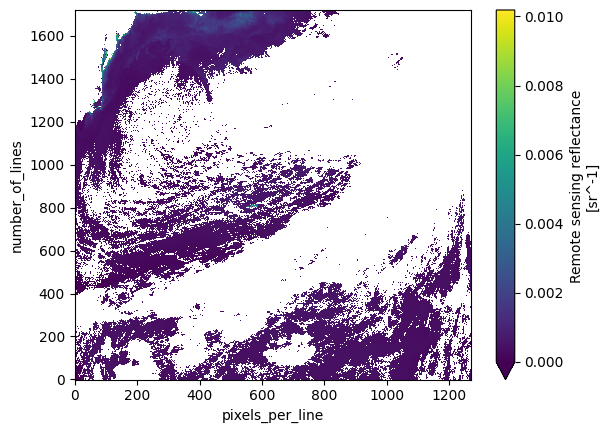

In [7]:
#We are indexing the Rrs variable and telling it to plot all the rows, all the columns, and just the 100th wavelength
df_geo['Rrs'][:,:,100].plot(cmap='viridis', vmin=0) #see https://matplotlib.org/stable/tutorials/colors/colormaps.html for other colormaps

#### Right now, the scene is being plotted using number_of_lines and pixels_per_line (x,y). Let's add some lat and lon values to map it in a real coordinate space. To do this, we need to create a new xarrray dataset and pull in information from the `navigational_data` group (df_nav).

In [8]:
rrs_xds = df_nav.rename({"pixel_control_points": "pixels_per_line"})
rrs_xds = xr.merge((df_geo, rrs_xds))
rrs_xds = rrs_xds.set_coords(("longitude", "latitude"))
rrs_xds

<xarray.Dataset>
Dimensions:       (number_of_lines: 1720, pixels_per_line: 1272,
                   wavelength_3d: 153)
Coordinates:
    longitude     (number_of_lines, pixels_per_line) float32 ...
    latitude      (number_of_lines, pixels_per_line) float32 ...
Dimensions without coordinates: number_of_lines, pixels_per_line, wavelength_3d
Data variables:
    Rrs           (number_of_lines, pixels_per_line, wavelength_3d) float32 ...
    Rrs_unc       (number_of_lines, pixels_per_line, wavelength_3d) float32 ...
    aot_865       (number_of_lines, pixels_per_line) float32 ...
    angstrom      (number_of_lines, pixels_per_line) float32 ...
    ipar          (number_of_lines, pixels_per_line) float32 ...
    nflh          (number_of_lines, pixels_per_line) float32 ...
    avw           (number_of_lines, pixels_per_line) float32 ...
    l2_flags      (number_of_lines, pixels_per_line) int32 ...
    cntl_pt_cols  (pixels_per_line) float64 ...
    cntl_pt_rows  (number_of_lines) float64 ...
    tilt          (number_of_lines) float32 ...

Although we now have coordinates, they won't help much because the data are not "gridded" by latitude and longitude.
The Level 2 data are the original instument swath, and have not been resampled to a regular grid. Therefore latitude
and longitude are known, but cannot be used to "look-up" values like you can along the dataset's dimensions.

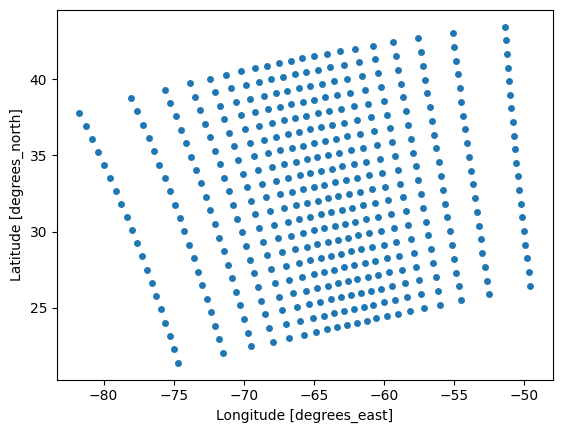

In [9]:
(
    rrs_xds
    .sel({
        "number_of_lines": slice(None, None, 1720//20),
        "pixels_per_line": slice(None, None, 1272//20),
    })
    .plot.scatter(x="longitude", y="latitude")
)

#### Let's plot this new xarray dataset the same way as before, but add lat, lon

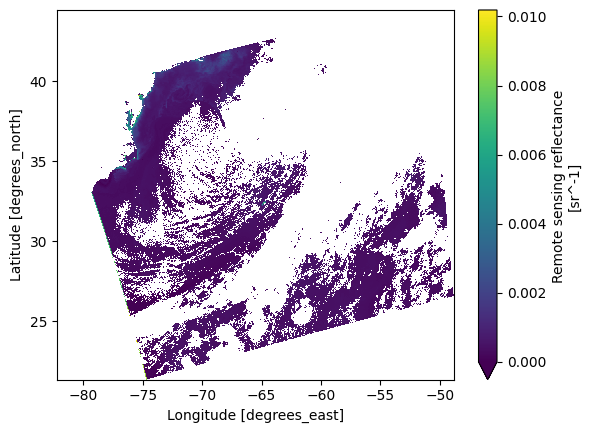

In [10]:
#We are indexing the Rrs variable and telling it to plot all the lats, lons, and the 100th wavelength
rrs_xds.Rrs[:,:,100].plot(x='longitude', y='latitude', cmap='viridis', vmin=0)

#### Notice the lat, lon values on the x,y axes and the shift of map

### Let's zoom into an area of interest - the Chesapeake Bay - by subsetting the data

In [11]:
rrs_xds_subset = rrs_xds.where(
    (rrs_xds["longitude"] >= -77) &
    (rrs_xds["longitude"] <= -74) &
    (rrs_xds["latitude"] >= 34) &
    (rrs_xds["latitude"] <= 40),
    drop=True,
)
rrs_xds_subset

<xarray.Dataset>
Dimensions:       (number_of_lines: 592, pixels_per_line: 148,
                   wavelength_3d: 153)
Coordinates:
    longitude     (number_of_lines, pixels_per_line) float32 -76.7 ... -74.27
    latitude      (number_of_lines, pixels_per_line) float32 33.38 33.4 ... 40.6
Dimensions without coordinates: number_of_lines, pixels_per_line, wavelength_3d
Data variables:
    Rrs           (number_of_lines, pixels_per_line, wavelength_3d) float32 n...
    Rrs_unc       (number_of_lines, pixels_per_line, wavelength_3d) float32 n...
    aot_865       (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    angstrom      (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    ipar          (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    nflh          (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    avw           (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    l2_flags      (number_of_lines, pixels_per_line) float64 nan nan ... nan nan
    cntl_pt_cols  (pixels_per_line, number_of_lines) float64 nan nan ... nan nan
    cntl_pt_rows  (number_of_lines, pixels_per_line) float64 nan nan ... nan nan
    tilt          (number_of_lines, pixels_per_line) float32 nan nan ... nan nan

#### And now let's plot it!

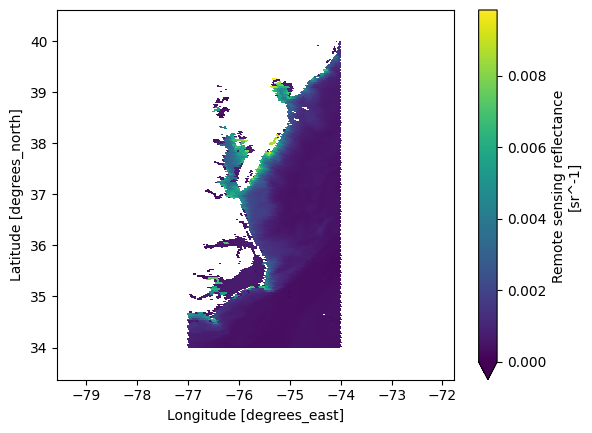

In [12]:
rrs_xds_subset.Rrs[:,:,100].plot(x='longitude', y='latitude', cmap='viridis', vmin=0)
#plt.axis([-77, -74, 34, 40]) #changes the plotting axes

### If you wanna get fancy, add the coastline

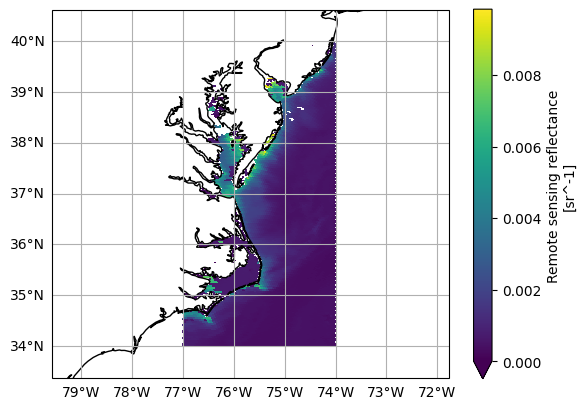

In [13]:
import cartopy.crs as ccrs

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})

rrs_xds_subset.Rrs[:,:,100].plot(x='longitude', y='latitude', cmap='viridis', vmin=0)

## Step 4: Plot a hyperspectral Rrs spectrum from one pixel

### Let's extract all data from one pixel located near (37, -75)- the red point on the map below

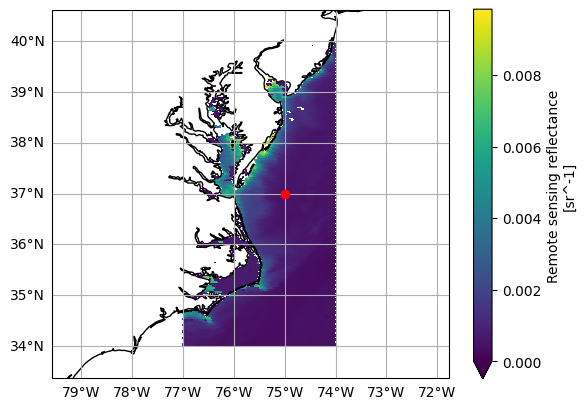

In [14]:
ax.plot(-75, 37, marker='o', color='red') #adding red point to extract data from
fig

With some educated guessing, we can find nearby indices in the swath dimensions.

In [15]:
rrs_xds_point = rrs_xds_subset.sel({
    "number_of_lines": 296,
    "pixels_per_line": 74,
})
rrs_xds_point.coords

Coordinates:
    longitude  float32 -75.04
    latitude   float32 37.1

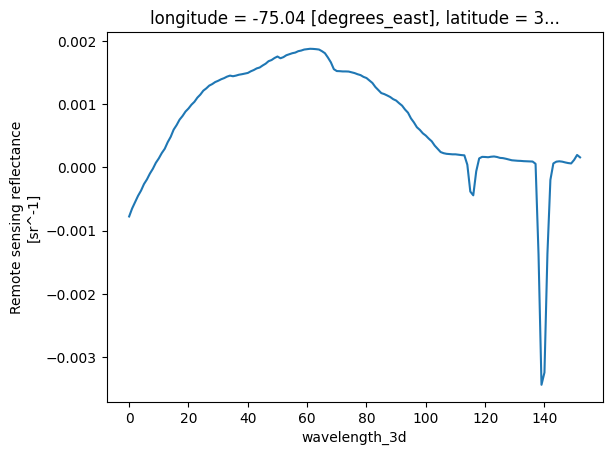

In [16]:
rrs_xds_point["Rrs"].plot.line()